<a href="https://colab.research.google.com/github/slunara/car_damage_detector/blob/main/models/EfficientNetV2S_car_damage_classifier_GridSearch_AppDpmt_noDataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car damage classifier

EfficientNetV2S pre trained model is used to classify where the image contain the damaged car or not.

In [1]:
#import necessary librabry
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Download data

Two datasets are used

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anujms/car-damage-detection")

print("Path to dataset files:", path)

100%|██████████| 123M/123M [00:03<00:00, 41.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1


In [3]:
import os

# Define the dataset path
dataset_path = "/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a"

# List files and folders
os.listdir(dataset_path)

['validation', 'training']

In [4]:
#defining the base, train and validation directory path
base_dir = "/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a"
train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
#defining the damage and whole , train and validation directory
train_damage_dir = os.path.join(train_dir, '00-damage')
train_whole_dir = os.path.join(train_dir, '01-whole')
validation_damage_dir = os.path.join(validation_dir, '00-damage')
validation_whole_dir = os.path.join(validation_dir, '01-whole')

## Preprocess the data

Data Augmentation is used to:
1. Rescale the data
2. to bring all the image to same dimension  i.e. 150x150


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


## Fine tune EfficientNetV2S

For training 1840 images are used.
For Validation 460 image are used.

Training and evaluating the model with binary crossentropy loss, accuracy, precision , recall

    # Define ImageDataGenerator for data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No augmentation for validation

    # Load datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=bs,
        class_mode="binary"
    )

    validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=bs,
        class_mode="binary"
    )

In [8]:
# Import necessary modules
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import EfficientNetV2S  # EfficientNetV2 Small
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from itertools import product

# Define hyperparameter grid
LEARNING_RATES = [1e-4]
BATCH_SIZES = [16]
DROPOUT_RATES = [0.3]
OPTIMIZERS = ["rmsprop"]

best_model = None
best_val_acc = 0
best_hyperparams = None

# Grid Search over hyperparameter combinations
for lr, bs, dropout, opt in product(LEARNING_RATES, BATCH_SIZES, DROPOUT_RATES, OPTIMIZERS):
    print(f"\n🔍 Training with: LR={lr}, Batch Size={bs}, Dropout={dropout}, Optimizer={opt}")

    # Load EfficientNetV2 base model (without top layers)
    base_model = EfficientNetV2S(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze early layers for transfer learning

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dropout(dropout)(x)  # Tunable dropout rate
    x = Dense(1, activation="sigmoid")(x)  # Binary classification

    # Define final model
    model = Model(base_model.input, x)

    # Choose optimizer
    if opt == "adam":
        optimizer = Adam(learning_rate=lr)
    elif opt == "rmsprop":
        optimizer = RMSprop(learning_rate=lr)

    # Compile model
    model.compile(loss="binary_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy", "Precision", "Recall"])


    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,  # Reduce epochs for fast grid search
        validation_data=validation_generator,
        verbose=2
    )

    # Get best validation accuracy
    val_acc = max(history.history["val_accuracy"])

    # Track the best performing model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hyperparams = (lr, bs, dropout, opt)
        best_model = model

print(f"\n🔥 Best Hyperparameters: LR={best_hyperparams[0]}, Batch Size={best_hyperparams[1]}, Dropout={best_hyperparams[2]}, Optimizer={best_hyperparams[3]}")


🔍 Training with: LR=0.0001, Batch Size=16, Dropout=0.3, Optimizer=rmsprop
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 - 76s - 831ms/step - Precision: 0.5711 - Recall: 0.5848 - accuracy: 0.5728 - loss: 0.6756 - val_Precision: 0.6093 - val_Recall: 0.8000 - val_accuracy: 0.6435 - val_loss: 0.6528
Epoch 2/100
92/92 - 6s - 64ms/step - Precision: 0.5980 - Recall: 0.6598 - accuracy: 0.6082 - loss: 0.6543 - val_Precision: 0.6778 - val_Recall: 0.5304 - val_accuracy: 0.6391 - val_loss: 0.6381
Epoch 3/100
92/92 - 7s - 72ms/step - Precision: 0.6210 - Recall: 0.6554 - accuracy: 0.6277 - loss: 0.6412 - val_Precision: 0.6640 - val_Recall: 0.7130 - val_accuracy: 0.6761 - val_loss: 0.6245
Epoch 4/100
92/92 - 6s - 68ms/step - Precision: 0.6478 - Recall: 0.6598 - accuracy: 0.6505 - loss: 0.6325 - val_Precision: 0.6323 - val_Recall: 0.8000 - val_accuracy: 0.6674 - val_loss: 0.6193
Epoch 5/100
92/92 - 7s - 72ms/step - Precision: 0.6218 - Recall: 0.6522 - accuracy: 0.6277 - loss: 0.6340 - val_Precision: 0.6806 - val_Recall: 0.6391 - val_accuracy: 0.6696 - val_loss: 0.6118
Epoch 6/100
92/92 - 6s - 65ms/step - Precisio

In [9]:
model=best_model
#weights saving
model.save("classifier.keras")

In [10]:
# Ensure the best model exists before conversion
if best_model:
    # Save the best model as TensorFlow Lite Model
    converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
    tflite_model = converter.convert()

    # Save TFLite model
    with open("best_model.tflite", "wb") as f:
        f.write(tflite_model)

    print("✅ Best model successfully converted to TensorFlow Lite format!")

    # Save labels
    labels = "\n".join(train_generator.class_indices.keys())  # Fix variable reference
    with open("labels.txt", "w") as f:
        f.write(labels)

    print("✅ Labels saved to labels.txt")
else:
    print("⚠️ No best model found! Ensure training completed successfully.")

Saved artifact at '/tmp/tmpjurk0y44'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133010595355088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010598006416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010883141584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010598004880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010883141200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010865916048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010883141776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010598012176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010599138448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133010598007568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13300866099816

In [11]:
!ls -lh best_model.tflite labels.txt

-rw-r--r-- 1 root root 80M Feb 20 17:13 best_model.tflite
-rw-r--r-- 1 root root  18 Feb 20 17:13 labels.txt


In [12]:
from google.colab import files

files.download("best_model.tflite")
files.download("labels.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

plotting the history of train and validation loss, accurcy, precision, recall

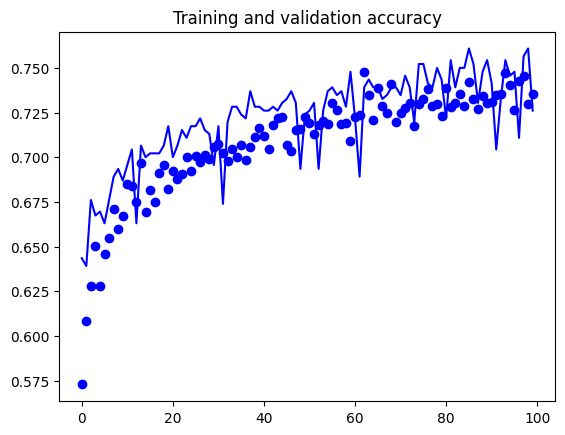

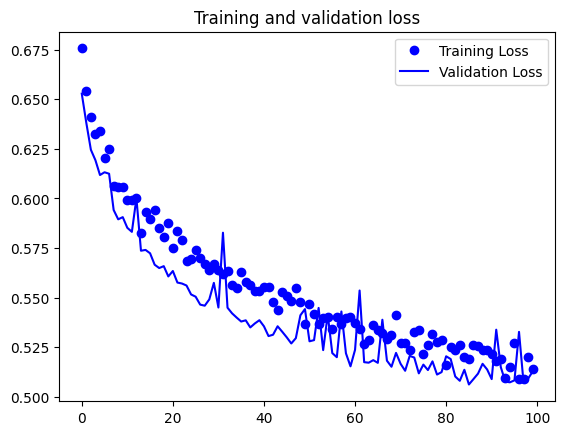

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

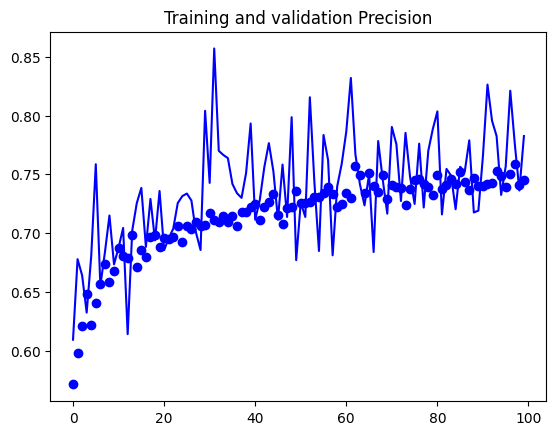

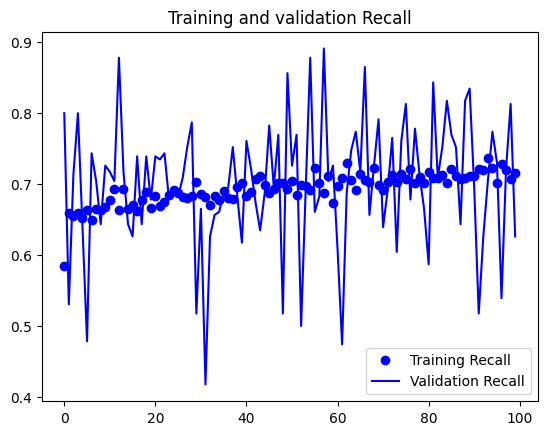

In [14]:
import matplotlib.pyplot as plt
acc = history.history['Precision']
val_acc = history.history['val_Precision']
loss = history.history['Recall']
val_loss = history.history['val_Recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Precision')
plt.plot(epochs, val_acc, 'b', label='Validation Precision')
plt.title('Training and validation Precision')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Recall')
plt.plot(epochs, val_loss, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.show()

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
The car is damaged


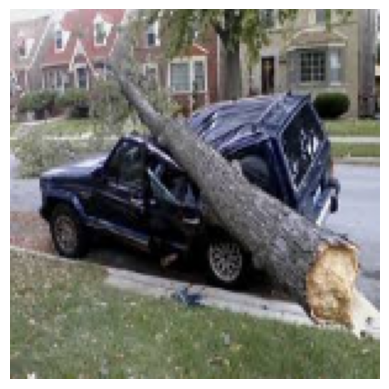

In [15]:
import cv2
im = cv2.imread("/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a/validation/00-damage/0001.JPEG")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.97947145]]
The car is not damaged


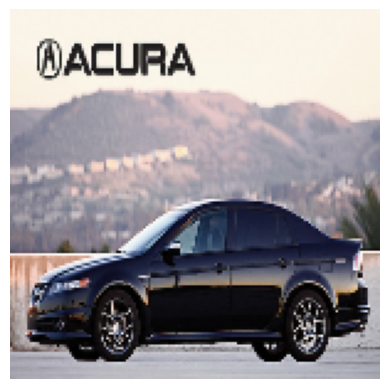

In [16]:
im = cv2.imread("/root/.cache/kagglehub/datasets/anujms/car-damage-detection/versions/1/data1a/validation/01-whole/0006.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (150, 150))
imS=im.reshape([1,150,150,3])
pred=model.predict(np.array(imS))
print(pred)
if pred[0][0]<0.5:
    print("The car is damaged")
else:
    print("The car is not damaged")
plt.axis("off")
plt.imshow(im)


Conclusion: Successfully build a classifier to classify the images containing into damage and undamage cars.

# Inference - SURA data

In [17]:
# Clone the GitHub repo
repo_url = "https://github.com/slunara/car_damage_detector.git"
!git clone {repo_url}

test_data_dir = "car_damage_detector/test_data"

assert os.path.exists(test_data_dir), "Test data folder not found!"
print("Test data downloaded successfully!")

Cloning into 'car_damage_detector'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 243 (delta 0), reused 2 (delta 0), pack-reused 238 (from 2)
Receiving objects: 100% (243/243), 91.43 MiB | 28.25 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (160/160), done.
Test data downloaded successfully!


In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Define image size
IMG_SIZE = (150, 150)

# Define class labels (damage = 1, whole = 0)
class_labels = {"damage": 0, "whole": 1}

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=IMG_SIZE)  # Load and resize
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = preprocess_input(img_array)  # Normalize
    return img_array

# Function to load test images from both classes
def load_test_images(test_data_dir):
    test_images = []
    test_labels = []
    test_filenames = []

    for category in ["damage", "whole"]:  # Iterate over both classes
        folder_path = os.path.join(test_data_dir, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img_array = load_and_preprocess_image(img_path)
            test_images.append(img_array)
            test_labels.append(class_labels[category])
            test_filenames.append(img_name)

    return np.array(test_images), np.array(test_labels), test_filenames

# Load test images
X_test, y_test, filenames = load_test_images(test_data_dir)

print(f"Loaded {len(X_test)} test images!")

Loaded 151 test images!


In [19]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Evaluate the model
accuracy = np.mean(y_pred_labels.flatten() == y_test)
print(f"✅ Model Accuracy on Test Data: {accuracy * 100:.2f}%")



5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
✅ Model Accuracy on Test Data: 68.87%


In [20]:
from sklearn.metrics import recall_score

# Calculate recall score
recall = recall_score(y_test.flatten(), y_pred_labels)

# Print recall score
print(f"✅ Model Recall on Test Data: {recall:.4f}")

✅ Model Recall on Test Data: 0.7299


FileNotFoundError: [Errno 2] No such file or directory: 'car_damage_detector/test_data/whole/Eok134_vehicle_03022025_082849_Right-1.jpg'

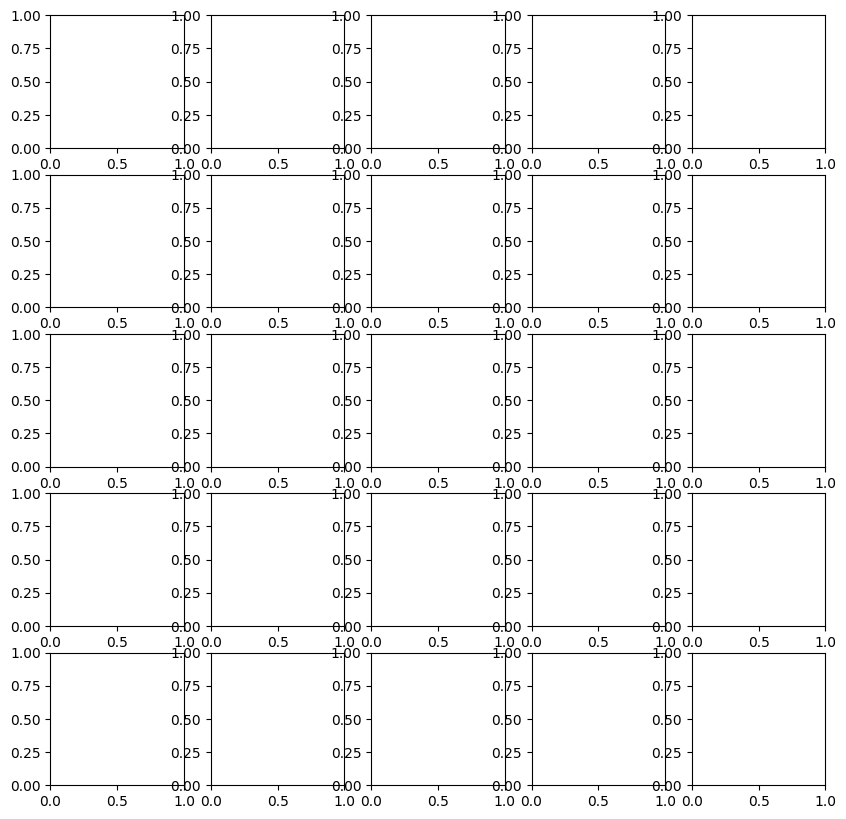

In [21]:
# Show sample predictions
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.ravel()

for i in range(25):
    img = load_img(os.path.join(test_data_dir, "damage" if y_test[i] == 1 else "whole", filenames[i]), target_size=IMG_SIZE)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Actual: {'Damage' if y_test[i] == 1 else 'Whole'}\nPredicted: {'Damage' if y_pred_labels[i] == 1 else 'Whole'}")

plt.show()

## Code to deploy the final model into a mobile app